In [79]:
stocks = ['AAPL','C','COST','CVX','DIS','HON','IBM',
         'JNJ','JPM','MCD','MDT','MRK','MSFT',
          'NEE','NKE','ORCL','PEP','PFE','PG',
          'UNP','UTX','VZ','WMT','XOM','HD',
          'KO','CMCSA','SPY'
         ]
import quandl
import pandas as pd
import pytz
from collections import OrderedDict

    
quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
data = OrderedDict()
for i in stocks:
    print(i)
    data[i] = quandl.get('EOD/{}'.format(i),start_date='1997-01-01', end_date='2009-01-25')
    data[i] = data[i][['Open','High','Low','Close','Volume']]
    data[i] = data[i].rename(columns={"Open": "open", "High": "high",'Close':"close","Low":"low","Volume":"volume"})
    print(data[i].head())
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

AAPL
             open   high    low  close      volume
Date                                              
1997-01-02  21.12  21.25  20.75  21.00   1277800.0
1997-01-03  21.12  22.25  21.00  21.75   1068900.0
1997-01-06  17.62  18.34  17.25  17.87  16811000.0
1997-01-07  18.12  18.25  17.50  17.50   8722600.0
1997-01-08  18.25  18.37  17.37  17.62   9822600.0
C
             open   high    low  close     volume
Date                                             
1997-01-02  45.13  45.75  43.75  44.50  1578667.0
1997-01-03  45.00  45.75  44.25  45.13  1463333.0
1997-01-06  45.00  46.13  45.00  45.38  1477667.0
1997-01-07  45.13  45.13  44.25  45.00  1672333.0
1997-01-08  45.13  45.63  44.75  44.88  1450000.0
COST
             open   high    low  close     volume
Date                                             
1997-01-02  25.25  25.25  24.12  24.37  1396600.0
1997-01-03  24.25  24.25  23.75  24.12  3191800.0
1997-01-06  24.12  24.75  24.12  24.69  2393000.0
1997-01-07  24.75  25.25  24.50

             open   high    low  close     volume
Date                                             
1997-01-02  50.25  50.38  48.88  49.13  1526467.0
1997-01-03  49.50  50.25  49.38  49.75  1597800.0
1997-01-06  49.88  50.50  49.88  50.25  2251867.0
1997-01-07  50.00  51.38  49.63  51.38  2817600.0
1997-01-08  52.00  52.00  50.88  51.25  3463267.0
KO
             open   high    low  close     volume
Date                                             
1997-01-02  52.13  52.50  51.13  51.88  3580900.0
1997-01-03  52.50  53.38  52.25  53.13  2656000.0
1997-01-06  53.25  53.63  52.25  52.63  3129800.0
1997-01-07  52.13  54.38  51.88  54.38  3662700.0
1997-01-08  54.13  54.50  53.13  53.38  2856000.0
CMCSA
             open   high    low  close     volume
Date                                             
1997-01-02  17.50  17.75  17.00  17.25   612400.0
1997-01-03  17.25  17.50  17.13  17.50   502200.0
1997-01-06  17.50  17.63  17.13  17.19   574800.0
1997-01-07  17.13  17.50  17.13  17.50   

In [80]:
panel = pd.Panel(data)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 28 (items) x 3035 (major_axis) x 5 (minor_axis)
Items axis: AAPL to SPY
Major_axis axis: 1997-01-02 00:00:00 to 2009-01-23 00:00:00
Minor_axis axis: open to volume


In [84]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from zipline.api import order_target_percent, record, symbol,get_datetime,set_benchmark,order,order_percent,get_open_orders,symbols,schedule_function
from zipline.finance import commission
from zipline import run_algorithm
from zipline.utils.events import date_rules, time_rules  
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pandas as pd
import datetime
import pickle
from abc import abstractmethod
from collections import defaultdict

from six import with_metaclass
from toolz import merge

from zipline.assets import Equity, Future
from zipline.finance.constants import FUTURE_EXCHANGE_FEES_BY_SYMBOL
from zipline.finance.shared import AllowedAssetMarker, FinancialModelMeta
from zipline.utils.dummy import DummyMapping

selected_stock =['AAPL','C','COST','CVX','DIS','HON','IBM',
         'JNJ','JPM','MCD','MDT','MRK','MSFT',
          'NEE','NKE','ORCL','PEP','PFE','PG',
          'UNP','UTX','VZ','WMT','XOM','HD',
          'KO','CMCSA'
         ]
# parameters 

def initialize(context):
    context.time = 0
    context.stocks = symbols('AAPL','C','COST','CVX','DIS','HON','IBM',
         'JNJ','JPM','MCD','MDT','MRK','MSFT',
          'NEE','NKE','ORCL','PEP','PFE','PG',
          'UNP','UTX','VZ','WMT','XOM','HD',
          'KO','CMCSA')
    context.max_positions = 30
    context.window = 252
    set_benchmark(symbol('SPY'))
    # 1. manually setting the commission
    context.set_commission(commission.PerTrade(cost=0.0005))

def handle_data(context, data):
    final = pd.read_csv('test3.csv')
    final["Date"]=pd.to_datetime(final["Date"])
    quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
    ben = quandl.get('EOD/SPY'.format(i),start_date='2007-01-05', end_date='2008-12-31')
    ben['return'] = ben["Close"]/ben["Close"].shift(1) - 1
    ben = ben.reset_index()
    # 2. warm-up period
    tday=get_datetime().date()
    beg = '['
    end = ']'
    r1 = ben[ben['Date']==tday]['return'].values[0]
    if context.time == 0:
        context.time += 1
        cleaned_weights = []
        
        # extract prices
        prices = data.history(context.stocks, fields='price',
                          bar_count=context.window + 1, frequency='1d')
        # calculate expected returns and sample covariance amtrix
        avg_returns = expected_returns.mean_historical_return(prices)
        cov_mat = risk_models.sample_cov(prices)

        # get weights maximizing the Sharpe ratio
        ef = EfficientFrontier(avg_returns, cov_mat)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        print(cleaned_weights)
    # submit orders
        for asset in context.stocks:
            order_target_percent(asset, cleaned_weights[asset])
            #order_target_percent(asset, 1/len(context.stocks))
    else:
        context.time += 1
        for stock in context.stocks:
            st = str(stock)
            b = str(stock).index(beg)
            e = str(stock).index(end)
            st = st[b+1:e]
            pr = final[final["Date"]==tday][st].values[0]
            current_position = context.portfolio.positions[stock].amount
    # 5. trading logic
            if pr>0.005:
                number_stock = round(pr*current_position)
                order(stock, 0.5*number_stock)
                if number_stock >0:
                    print(tday)
                    print('buy {} in number {}'.format(st,number_stock))
            elif pr<-0.005:
                number_stock = round(pr*current_position)
                order(stock, number_stock)
                if number_stock >0:
                    print(tday)
                    print('short {} in number {}'.format(st,number_stock))
    # save values for later inspection
        record(value=context.portfolio.portfolio_value,POS=current_position,
           SPY=r1,leverage=context.account.leverage,pro_returns = context.portfolio.returns)
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[10,10])
    # portfolio value
    perf[['value']].plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')

    # daily returns
    perf.algorithm_period_return.plot(ax=ax[1])
    perf.benchmark_period_return.plot(ax=ax[1])
    ax[1].set_ylabel('daily returns')
    ax[1].legend()
    
    perf.leverage.plot(ax=ax[2])
    ax[2].set_ylabel('leverage')
    ax[2].legend()
    
    fig.suptitle('Simple LSTM Strategy - {}'.format(selected_stock), fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))
    print(perf.tail())


{Equity(0 [JNJ]): 0.0, Equity(1 [ORCL]): 0.07456, Equity(2 [NEE]): 0.15762, Equity(3 [PFE]): 0.0, Equity(4 [MSFT]): 0.0, Equity(5 [IBM]): 0.0, Equity(6 [XOM]): 0.10709, Equity(7 [UTX]): 0.0, Equity(8 [NKE]): 0.09881, Equity(9 [CVX]): 0.0, Equity(10 [DIS]): 0.1686, Equity(11 [AAPL]): 0.0, Equity(12 [C]): 0.0, Equity(13 [HD]): 0.0, Equity(15 [MCD]): 0.00915, Equity(16 [COST]): 0.0, Equity(17 [HON]): 0.0, Equity(18 [MRK]): 0.10762, Equity(19 [CMCSA]): 0.27655, Equity(20 [MDT]): 0.0, Equity(21 [VZ]): 0.0, Equity(22 [PG]): 0.0, Equity(23 [JPM]): 0.0, Equity(24 [PEP]): 0.0, Equity(25 [UNP]): 0.0, Equity(26 [KO]): 0.0, Equity(27 [WMT]): 0.0}
2007-01-08
buy NKE in number 6.0
2007-01-08
buy ORCL in number 37.0
2007-01-09
buy NKE in number 6.0
2007-01-09
buy ORCL in number 26.0
2007-01-10
buy NKE in number 6.0
2007-01-11
buy NKE in number 6.0
2007-01-12
buy NKE in number 6.0
2007-01-12
buy ORCL in number 57.0
2007-01-16
buy NKE in number 6.0
2007-01-16
buy ORCL in number 43.0
2007-01-17
buy NKE 

2008-03-19
buy ORCL in number 50.0
2008-03-20
buy DIS in number 30.0
2008-03-20
buy ORCL in number 60.0
2008-03-24
buy ORCL in number 78.0
2008-03-25
buy ORCL in number 46.0
2008-03-26
buy ORCL in number 51.0
2008-03-27
buy ORCL in number 143.0
2008-03-28
buy ORCL in number 268.0
2008-03-31
buy ORCL in number 94.0
2008-04-07
buy ORCL in number 76.0
2008-04-09
buy ORCL in number 51.0
2008-04-10
buy ORCL in number 50.0
2008-04-11
buy ORCL in number 83.0
2008-04-14
buy ORCL in number 62.0
2008-04-16
buy DIS in number 26.0
2008-04-17
buy ORCL in number 74.0
2008-04-18
buy ORCL in number 58.0
2008-04-21
buy ORCL in number 57.0
2008-05-01
buy ORCL in number 73.0
2008-05-02
buy ORCL in number 73.0
2008-05-05
buy ORCL in number 65.0
2008-05-06
buy ORCL in number 52.0
2008-05-07
buy ORCL in number 49.0
2008-05-08
buy ORCL in number 63.0
2008-05-22
buy DIS in number 28.0
2008-05-23
buy DIS in number 31.0
2008-06-04
buy ORCL in number 45.0
2008-06-05
buy DIS in number 26.0
2008-06-13
buy ORCL in 

2008-12-12
buy NEE in number 34.0
2008-12-12
buy NKE in number 6.0
2008-12-12
buy ORCL in number 83.0
2008-12-12
buy CMCSA in number 28.0
2008-12-15
buy NEE in number 35.0
2008-12-15
buy NKE in number 9.0
2008-12-15
buy ORCL in number 96.0
2008-12-15
buy CMCSA in number 31.0
2008-12-16
buy NEE in number 32.0
2008-12-16
buy NKE in number 7.0
2008-12-16
buy ORCL in number 124.0
2008-12-16
buy CMCSA in number 31.0
2008-12-17
buy NEE in number 31.0
2008-12-17
buy NKE in number 6.0
2008-12-17
buy ORCL in number 212.0
2008-12-17
buy CMCSA in number 31.0
2008-12-18
buy NEE in number 30.0
2008-12-18
buy ORCL in number 176.0
2008-12-18
buy CMCSA in number 29.0
2008-12-19
buy NEE in number 32.0
2008-12-19
buy ORCL in number 198.0
2008-12-19
buy CMCSA in number 28.0
2008-12-22
buy DIS in number 31.0
2008-12-22
buy NEE in number 34.0
2008-12-22
buy ORCL in number 373.0
2008-12-22
buy CMCSA in number 27.0
2008-12-23
buy NEE in number 36.0
2008-12-23
buy ORCL in number 178.0
2008-12-23
buy CMCSA in 

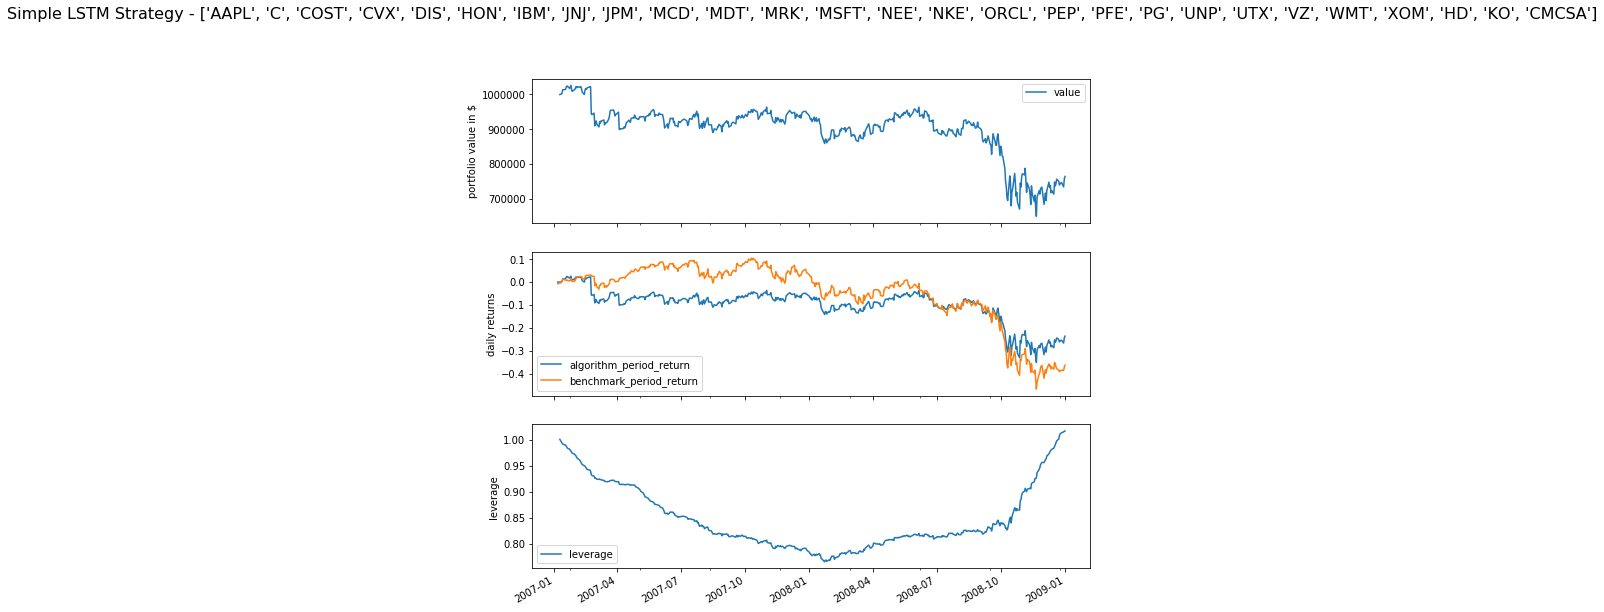

Final portfolio value (including cash): 763662.22$
                              POS       SPY  algo_volatility  \
2008-12-24 18:00:00+00:00  4872.0  0.005803         0.284214   
2008-12-26 21:00:00+00:00  4885.0  0.005770         0.283952   
2008-12-29 21:00:00+00:00  4897.0 -0.002868         0.283906   
2008-12-30 21:00:00+00:00  4897.0  0.023703         0.284522   
2008-12-31 21:00:00+00:00  4897.0  0.014274         0.284321   

                           algorithm_period_return     alpha  \
2008-12-24 18:00:00+00:00                -0.257357  0.051976   
2008-12-26 21:00:00+00:00                -0.253899  0.051868   
2008-12-29 21:00:00+00:00                -0.266450  0.044134   
2008-12-30 21:00:00+00:00                -0.243398  0.050812   
2008-12-31 21:00:00+00:00                -0.236338  0.049507   

                           benchmark_period_return  benchmark_volatility  \
2008-12-24 18:00:00+00:00                -0.388297              0.314156   
2008-12-26 21:00:00+00:00  

In [85]:
from zipline.api import order, record, symbol, set_benchmark,symbols
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
perf = zipline.run_algorithm(start=datetime(2007, 1, 5, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2008, 12, 31, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=1000000,
                      handle_data=handle_data,
                      analyze = analyze,
                      data=panel)
import pickle
with open('model_LSTM.pickle','wb') as f:
    pickle.dump(perf,f)

Start date,2007-01-05
End date,2008-12-31
Total months,23
,Backtest
Annual return,-12.7%
Cumulative returns,-23.6%
Annual volatility,28.4%
Sharpe ratio,-0.33
Calmar ratio,-0.34
Stability,0.50
Max drawdown,-36.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.74,2007-01-24,2008-11-20,NaT,NaN
1,0.68,2007-01-18,2007-01-22,2007-01-24,5
2,0.05,2007-01-05,2007-01-08,2007-01-09,3
3,0.00,2007-01-05,2007-01-05,2007-01-05,1
4,0.00,2007-01-05,2007-01-05,2007-01-05,1


Stress Events,mean,min,max
Lehman,-0.12%,-7.05%,3.80%
Aug07,0.07%,-2.16%,2.23%
Mar08,0.18%,-1.40%,2.45%
Sept08,-0.29%,-7.05%,3.80%
Low Volatility Bull Market,-0.05%,-7.58%,1.80%
GFC Crash,-0.03%,-9.15%,11.17%


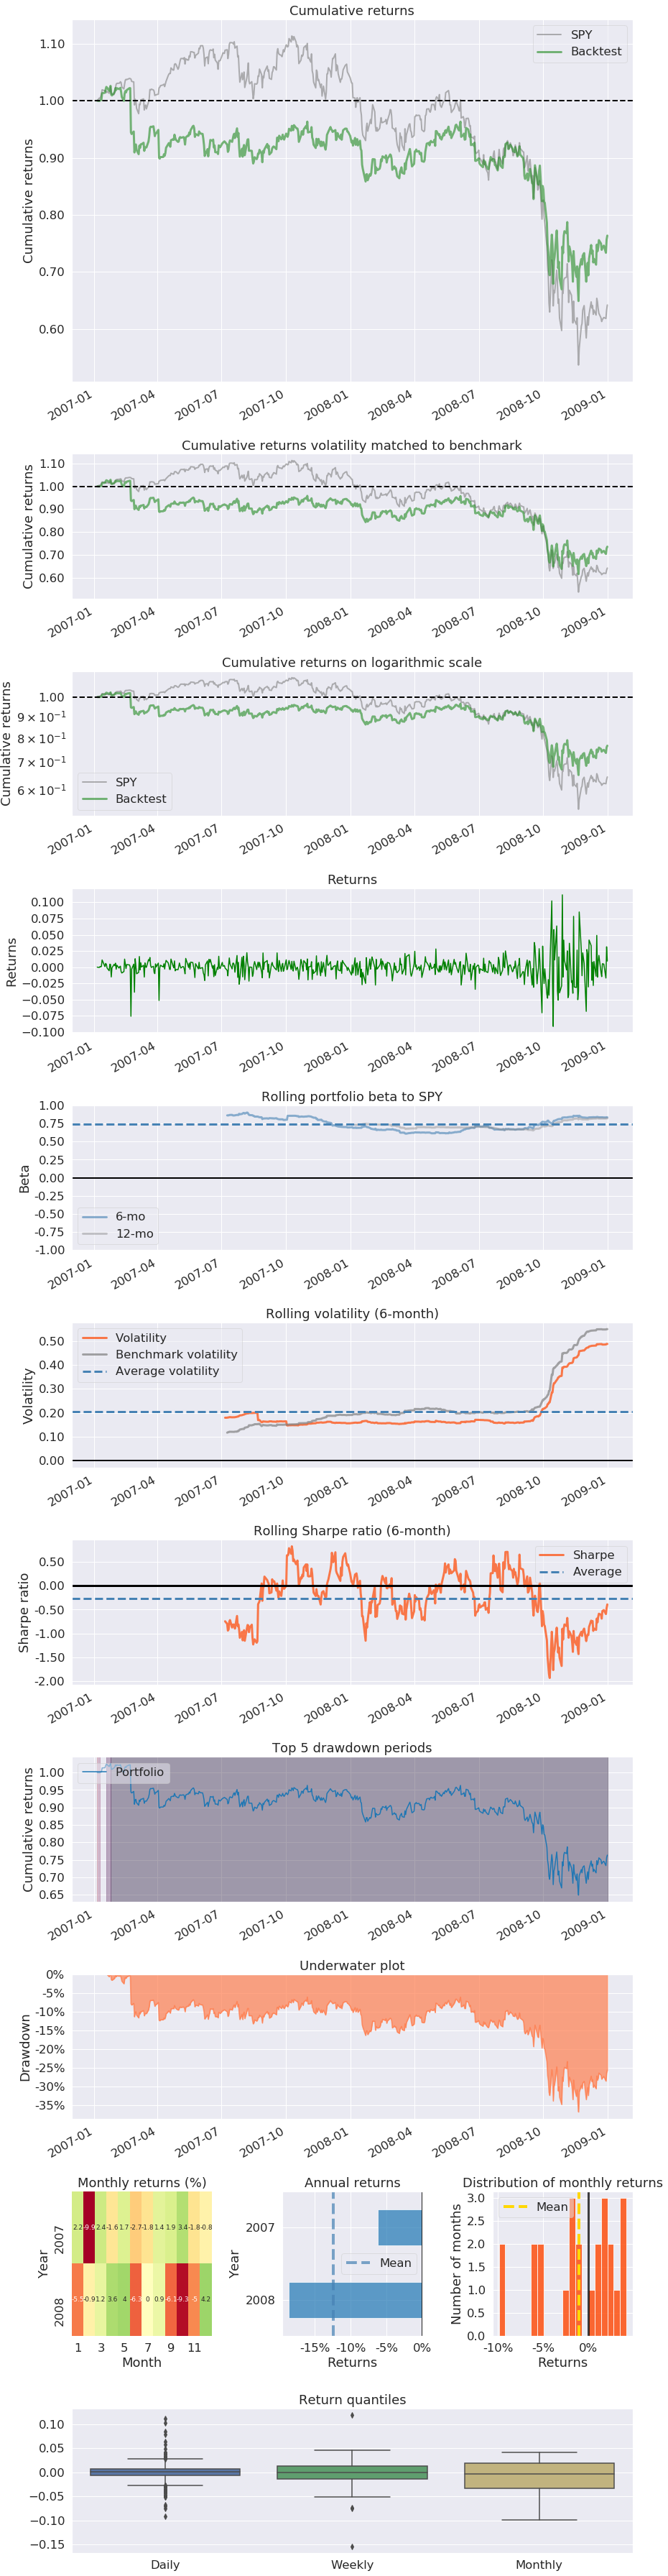

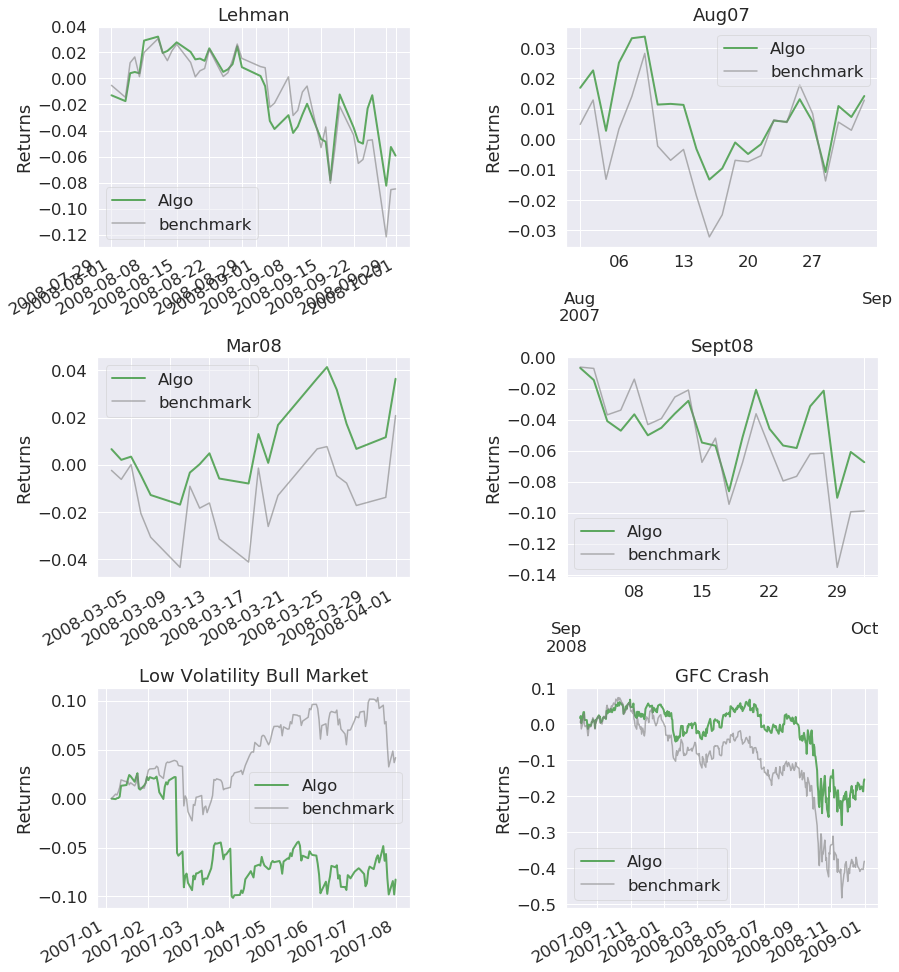

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
import warnings
import pyfolio as pf
LSTM_model3_results = pd.read_pickle('model_LSTM.pickle')
#print(LSTM_model3_results.columns)
SPY,returns, predict_returns = pf.utils.extract_rets_pos_txn_from_zipline(LSTM_model3_results)
algorithm = LSTM_model3_results.returns
SPY  =  LSTM_model3_results.SPY
pf.create_full_tear_sheet(algorithm,benchmark_rets=SPY)